# Assignment #2
---

## 1. Members
* 2017572006 SooYeon Lee
* 2017572012 YunSong Jeong
---

## 2. Load files (Checking)

In [102]:
import os
files = os.listdir('./Foliage')
files2 = os.listdir('./ManMade')
print ("Total number of files: Foliage(%s), ManMade(%s)"%(len(files), len(files2)))

Total number of files: Foliage(324), ManMade(419)


---
## 3. getSpectra

### Requirements
1. read in all tif-images in this directory
2. for each image, take the middle 512x512 pixels of this image
3. **window each image by a Gaussian of sigma 64 pixels –this is important to reduce the cross-artefacts**
4. calculate the **fft shifted log Fourier power spectrum** [using numpy] for each windowed image
5. return a numpy-array of all spectra

In a main script, display the average fftshifted log power spectrum for each of the two categories. What can you say? Insert your observation as comments.


### First, We should load pixels of images. (For convenience, We make photo to gray scale)

Size of image file : (576L, 768L)
RGB data of first pixel : 25


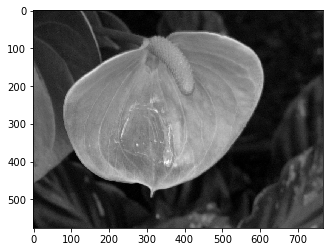

In [20]:
# For loading Pixels of image
import matplotlib.pyplot as plt
import cv2

img = cv2.imread('./Foliage/%s'%files[0], 0)
y_size,x_size = img.shape

print "Size of image file :",img.shape #Get the width and hight of the image for iterating over
print "RGB data of first pixel :" ,img[0,0] #Get the RGB Value of the a pixel of an image

# Drawing
plt.imshow(img, cmap = 'gray')
plt.show()

### We should cut it out to 512x512

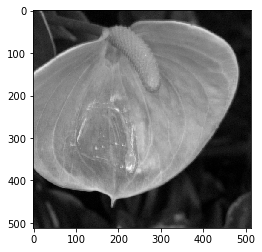

In [21]:
# We should substract half of oversize to head and tail
y_size,x_size = img.shape

cuts_x = int((x_size-512)/2)
cuts_y = int((y_size-512)/2)

## y,y+h, x:x+h (inversed)
crop_img = img[cuts_y:y_size-cuts_y, cuts_x:x_size-cuts_x]

# Drawing
plt.imshow(crop_img, cmap = 'gray')
plt.show()

### Gausian Filter to blur edge

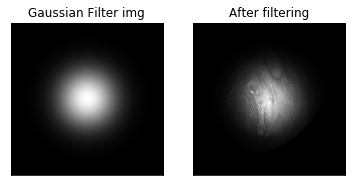

In [22]:
import numpy as np

def gaussian2(size, sigma):
    ## Calculate Gaussian 2D Filter
    A = 1/(2.0*np.pi*sigma**2)
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = A*np.exp(-((x**2/(2.0*sigma**2))+(y**2/(2.0*sigma**2))))
    return g

# 512x512 size and sigma value is 64
gaussian_filter=gaussian2(512, 64)
# Get maximum value in gaussian filter matrix
max_value = gaussian_filter.max()
gaussian_filter[256,256]

"""
ratio for make maximum multiple value to 1.
Abnormaly, Gaussian filter has probabilities that sum of all is 1, So we should get the ratio to make center
maintain the original color. (It's a trick..)
"""
ratio = 1/max_value

for i in range(0,512):
    for j in range(0,512):
        crop_img[i][j] *= gaussian_filter[i,j]*ratio
        crop_img[i][j] = int(crop_img[i][j])

# Drawing
plt.subplot(121),plt.imshow(gaussian_filter, cmap = 'gray')
plt.title('Gaussian Filter img'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(blur_img, cmap = 'gray')
plt.title('After filtering'), plt.xticks([]), plt.yticks([])
plt.show()

###  Then, We should get the fft shifted log Fourier power spectrum

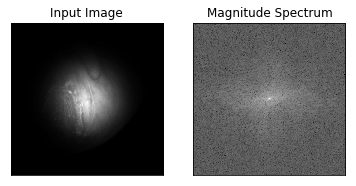

In [23]:

## Fourier Transform -> Shift -> Log
f = np.fft.fft2(crop_img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

# Drawing
plt.subplot(121),plt.imshow(crop_img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

### Now! We can merge it to one function

In [176]:
def getSpectra(dirname):
    print "Get Spectrum in %s"%dirname
    all_list = []
    all_avg = []
    files = os.listdir(dirname)
    for idx,file in enumerate(files):
        # 1. Load img
        img = cv2.imread('%s/%s'%(dirname,file), 0)

        # 2. Cut it to 512x512
        y_size,x_size = img.shape
        cuts_x = int((x_size-512)/2)
        cuts_y = int((y_size-512)/2)
        crop_img = img[cuts_y:y_size-cuts_y, cuts_x:x_size-cuts_x]
       
        # 3. Gaussian Filter
        
        gaussian_filter=gaussian2(512, 64)
        max_value = gaussian_filter.max()
        gaussian_filter[256,256]

        ratio = 1/max_value

        for i in range(0,512):
            for j in range(0,512):
                crop_img[i][j] *= gaussian_filter[i,j]*ratio
                crop_img[i][j] = int(crop_img[i][j])
                
        # 4. Fft shifted log fourier power spectrum
        newdir = dirname+'_spec/'+file
        # cv2.imwrite(newdir,crop_img)
        
        f = np.fft.fft2(crop_img)
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = 20*np.log(np.abs(fshift))
        
        # 5. Save as list of np.array
        all_list.append(magnitude_spectrum)
        all_avg.append(np.average(magnitude_spectrum))
    return all_list

### Main function

In [177]:
#Get all Spectrum!
Foliage_Spectrum = getSpectra('./Foliage')
ManMade_Spectrum = getSpectra('./ManMade')

Get Spectrum in ./Foliage
Get Spectrum in ./ManMade


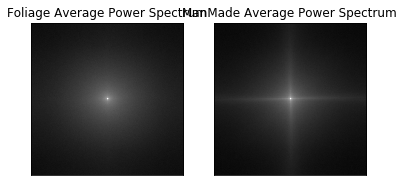

In [178]:
# Draw average data! (we can get array's average by using np.average and option axis=0)
average_Foliage = np.average(Foliage_Spectrum,axis=0)
average_ManMade = np.average(ManMade_Spectrum,axis=0)

# Left, Right
plt.subplot(121),plt.imshow(average_Foliage, cmap = 'gray')
plt.title('Foliage Average Power Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(average_ManMade, cmap = 'gray')
plt.title('ManMade Average Power Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

### Observation

* Foliage
    * little bit blurred and broad cross-line is observed
    * It seems to be no clear pattern in photos.
    
* ManMade
    * Clear, sharp and tilted cross-line is observed
    * Also, There is little bit dark gray line parallel with big clear white line

---

## 4. Radial Fourier Spectra

### Requirements:
Its input is a numpy array (a fftshifted log power spectrum) and it will radially average the values in the image starting from the middle and going into the farthest corner.


First, We should pick up the **pixels in the radius**.
To average, We should know the number of pixels and values of all pixels.

### If Radius is 10,

In [52]:
center = (255,255)

radius = 1

count = 0
for i in range(center[0]-radius, center[1]+radius+1):
    for j in range(center[0]-radius, center[1]+radius+1):
        distance = np.sqrt((i-center[0])**2 + (j-center[1])**2)
        if distance<=radius:
            count+=1
print "For radius %s, There is %s pixels" %(radius,count)

For radius 1, There is 5 pixels


### But It's too slow, so we can use np library, bitcount and ravel

In [130]:
def radialAverage(data, center):
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    
    return radialprofile 

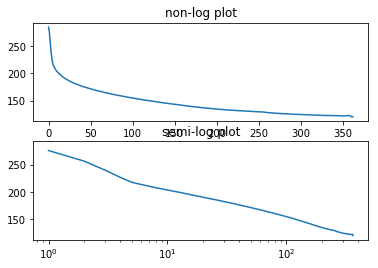

In [193]:
#center = np.unravel_index(img.argmax(), img.shape)
center = (255,255)
rad_profile = radialAverage(average_Foliage, center)

plt.subplot(211)
plt.plot(rad_profile)
plt.title('non-log plot')
plt.subplot(212)
plt.semilogx(rad_profile)
plt.title('semi-log plot')

plt.show()

### OK then, We can get the all data!!

In [180]:
center=(255,255)
radial_Foliage = radialAverage(average_Foliage,center)
radial_ManMade = radialAverage(average_ManMade,center)

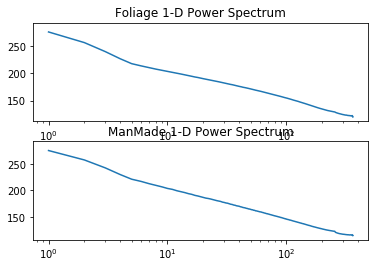

In [181]:
# Draw 1-D semilog Graph. (We can use semilogx in matplot library)

plt.subplot(211)
plt.semilogx( radial_Foliage)
plt.title('Foliage 1-D Power Spectrum')

plt.subplot(212)
plt.semilogx(radial_ManMade)
plt.title('ManMade 1-D Power Spectrum')

plt.show()

---
## 5. Determine the slope of statistics

### If We draw it to log-log function, the slope would become smaller

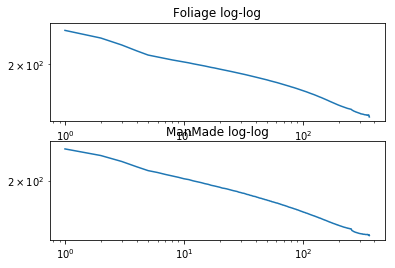

In [182]:
# Draw 1-D semilog Graph. (We can use semilogx in matplot library)

plt.subplot(211)
plt.loglog( radial_Foliage)
plt.title('Foliage log-log')

plt.subplot(212)
plt.loglog(radial_ManMade)
plt.title('ManMade log-log')

plt.show()

### Fit a line to it in the semilog

* np.polyfit : get the slope and y-intercept

In [188]:
x = range(1,len(radial_Foliage)+1)
p = np.polyfit(np.log(x),radial_Foliage, 1)

## p[0] = slope
## p[1] = y-intercept
print "For semilog, slope is %s"%p[0]

x = range(1,len(radial_ManMade)+1)
p = np.polyfit(np.log(x), np.log(radial_ManMade), 1)
print "For loglog, slope is %s"%p[0]

For semilog, slope is -25.7337105566
For loglog, slope is -0.17108573654


In [189]:
def fit1DSpectrum(array):
    x = range(1,len(array)+1)
    p = np.polyfit(np.log(x),array, 1)
    slope = p[0]
    return slope

### To draw box plot of all photos, we can use upper data.
* fftshifted log power data
    1. Foliage_Spectrum
    2. ManMade_Spectrum
    
### If not, Just add module `getspectra(dirname)`

In [183]:
Foliage_slope=[]
ManMade_slope=[]

for idx, spec in enumerate(Foliage_Spectrum):
    radial = radialAverage(spec,center)
    slope = fit1DSpectrum(radial)
    Foliage_slope.append(slope)
    
for idx,spec in enumerate(ManMade_Spectrum):
    radial = radialAverage(spec,center)
    slope = fit1DSpectrum(radial)
    ManMade_slope.append(slope)

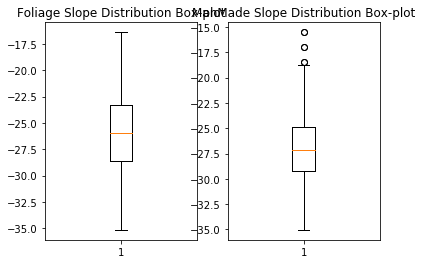

In [186]:
# Draw Box plot of slope distribution

plt.subplot(121)
plt.boxplot(Foliage_slope)
plt.title('Foliage Slope Distribution Box-plot')

plt.subplot(122)
plt.boxplot(ManMade_slope)
plt.title('ManMade Slope Distribution Box-plot')

plt.show()

---
## 6. Question

### 1. Build a classifier that tells the two categories apart based on the slope value – if yes, why? If no, why?

```
적합하지않다

The median of the manmade is lower than median of foliage, and some values above 18 in manmade are checked as outliers.
맨메이드가 약간 낮은 값을 보임, 
하지만 뚜렷하지는 않아서 slope만으로 classification을 하기에는 False값이 많을것이다.
값자체에 교집합 수가 많으니까

```

### 2. Build a classifier that tells the two categories apart based on some measure extracted on the spectrum – if yes, which measure do you propose? If no, why not?

```
Yes!
From spectrum images, We found clear difference between two categories.
ManMade photos have much sharper linear lines than Foliage photos.
It means, ManMade photos have radical change between pixels (similar to edge-effects)

To build a  classifier, we can use these differences.
비교적 명확한 라인이 생긴 스펙트럼을 가진 것이 맨메이드라고 판결 지을수 있을것이다

아래에 위에 생성했떤 그래프를 다시 그려보았다.
manmade가 훨씬 뚜렷한 격자 무늬가 있다.
```

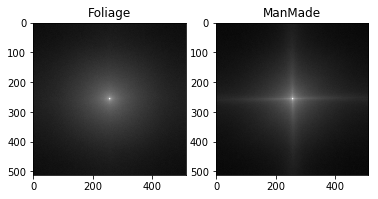

In [191]:
plt.subplot(121),plt.imshow(average_Foliage, cmap = 'gray')
plt.title('Foliage')
plt.subplot(122),plt.imshow(average_ManMade, cmap = 'gray')
plt.title('ManMade')
plt.show()